In [1]:
import pandas as pd
from isbtchot.model import btc_power_law
from isbtchot.schemas.args import TypeTime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
import seaborn as sns


In [2]:
df = btc_power_law()
df["delta"] = df.price / df.power_law

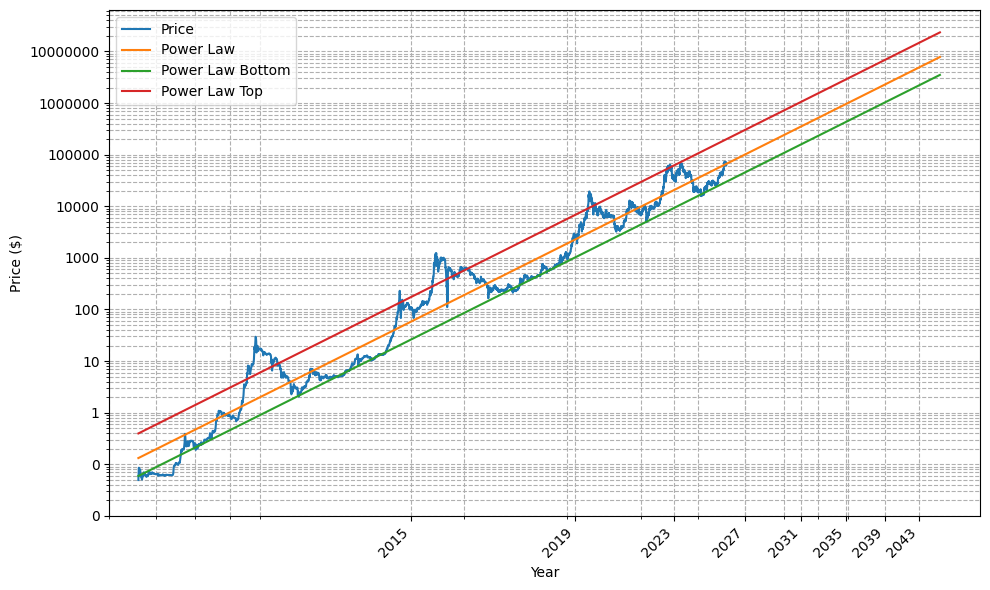

In [3]:
# Plotting the data
plt.figure(figsize=(10, 6))

# Plot both 'price' and 'power_law' on a log-log scale
plt.plot(df['days'], df['price'], label='Price')
plt.plot(df['days'], df['power_law'], label='Power Law')
plt.plot(df['days'], df['power_law_bottom'], label='Power Law Bottom')
plt.plot(df['days'], df['power_law_top'], label='Power Law Top')

# Setting log scale for both x and y axis
plt.xscale('log')
plt.yscale('log')

# Find the date range
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='4YS')

# Calculate the number of days since the start for each year start
xticks_yearly = [(date - df.index.min()).days for date in date_range]

# Generate yearly labels from the date_range
xticklabels_yearly = [date.strftime('%Y') for date in date_range]

# Setting ticks on the x-axis to correspond to the start of each year
plt.xticks(ticks=xticks_yearly, labels=xticklabels_yearly, rotation=45, ha='right')

# Setting the axis labels
plt.xlabel('Year')
plt.ylabel('Price ($)')

# Set the formatter for the y-axis to plain (no scientific notation)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.gca().yaxis.set_minor_formatter(NullFormatter())

# Adding legend and grid
plt.legend()
plt.grid(True, which="both", ls="--")

# Adding limits
plt.xlim(left=500)
plt.ylim(bottom=0.01)

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots.
plt.show()

In [4]:
df.dropna().tail(1)

,price,days,power_law,power_law_bottom,power_law_top,delta
2024-04-22,66119.75,5588,66318.472603,29843.312671,198955.417808,0.997004


In [5]:
df.loc[pd.Timestamp(year=2025, month=1, day=25)]


price                         NaN
days                  5866.000000
power_law            87489.513676
power_law_bottom     39370.281154
power_law_top       262468.541028
delta                         NaN
Name: 2025-01-25 00:00:00, dtype: float64

In [6]:
df[df.power_law > 1_000_000].head(1)

,price,days,power_law,power_law_bottom,power_law_top,delta
2033-08-15,NaN,8990,1.000018e+06,450008.259836,3.000055e+06,NaN


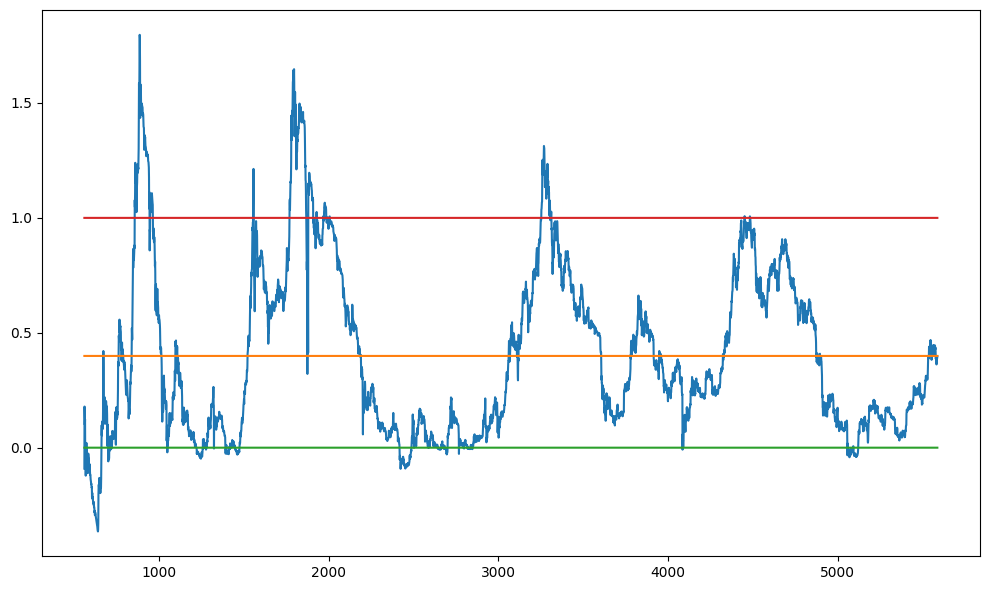

In [7]:
delta = (np.log(df["delta"].dropna()) - np.log(0.45)) / 2
days = df["days"][:len(delta)]

plt.figure(figsize=(10, 6))

# Plot data
plt.plot(days, delta, label='Delta')
plt.plot(days,[(0 - np.log(0.45)) / 2 for _ in delta])
plt.plot(days,[0 for _ in delta])
plt.plot(days,[1 for _ in delta])

# Show the plot
plt.tight_layout()
plt.show()

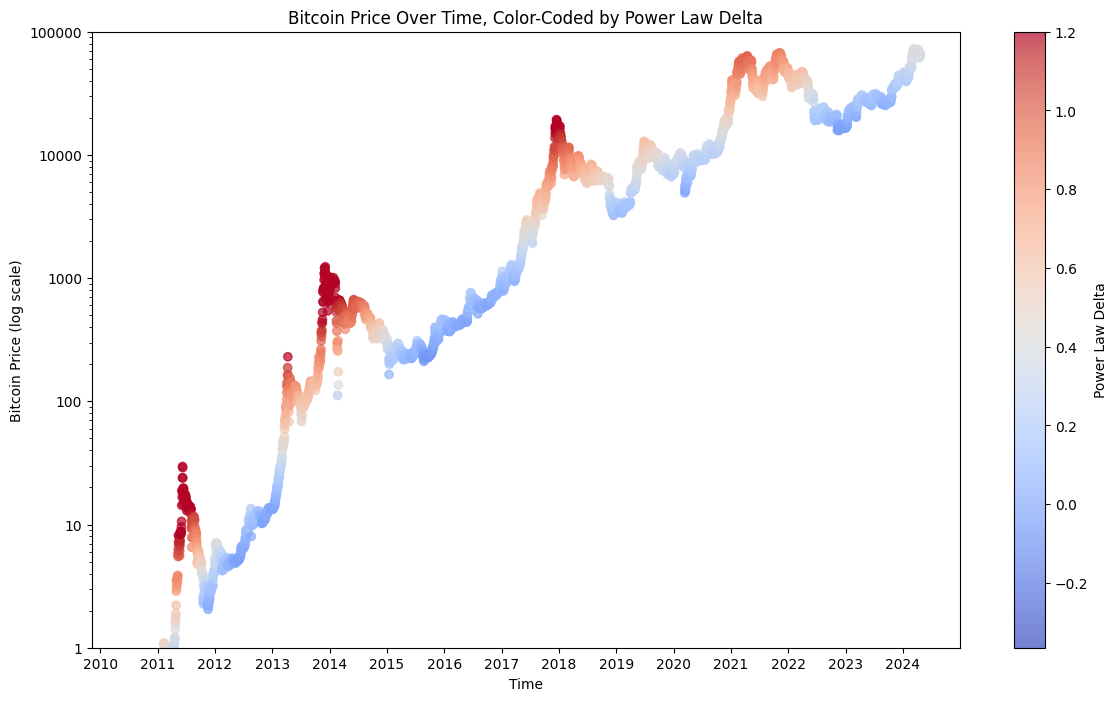

In [8]:
# Parse the dates in the format provided (day/month/year)
df['time'] = pd.to_datetime(df.index)

fig, ax = plt.subplots(figsize=(14, 8))

# Scatter plot for Bitcoin price
sc = ax.scatter(df['time'], df['price'], c=((np.log(df["delta"]) - np.log(0.45)) / 2).clip(upper=1.2), cmap="coolwarm", alpha=0.7)

# Log scale for the price
ax.set_yscale('log')
from matplotlib.ticker import StrMethodFormatter, NullFormatter
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.yaxis.set_minor_formatter(NullFormatter())
ax.set_ylim([1, 100_000])

# Set the x-axis to only show the years as labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add color bar to the right of the plot
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Power Law Delta')

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Bitcoin Price (log scale)')
ax.set_title('Bitcoin Price Over Time, Color-Coded by Power Law Delta')

plt.show()

Current:
 2024-04-22   -0.003001
Name: delta, dtype: float64


<Axes: >

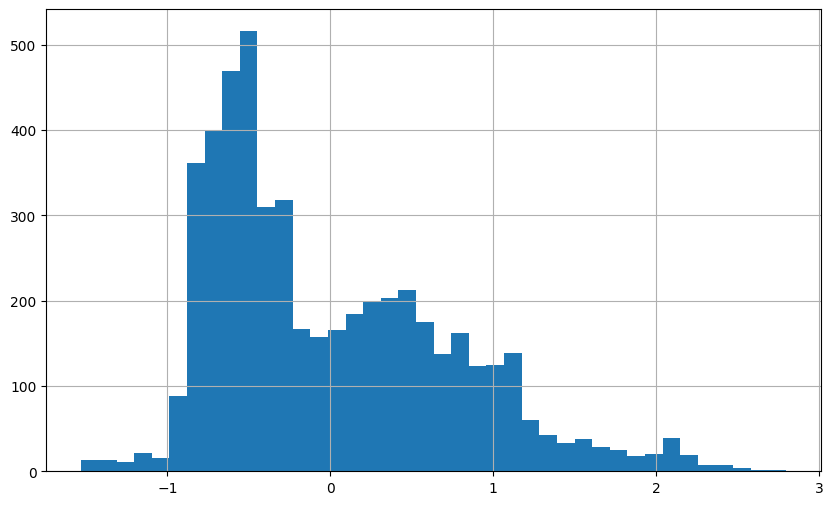

In [9]:
print("Current:\n", np.log(df.dropna().tail(1).delta))
plt.figure(figsize=(10, 6))

np.log(df.delta).hist(bins=40)

In [10]:
# Assuming btc_power_law is a function that returns a DataFrame.
df = btc_power_law()
prices = df["price"].values
power_law_bottoms = df["power_law_bottom"].values
dates = df.index.to_series().reset_index(drop=True)
days_premium = np.full(df.shape[0], np.nan)
price_went_below = np.full(df.shape[0], False)

# Avoid nested loops by processing in a more efficient manner
for i in range(len(prices)):
    curr_price = prices[i]
    
    condition_met = np.where(curr_price - power_law_bottoms[i:] < 0)[0]
    if condition_met.size > 0:
        first_met_index = condition_met[0] + i
        days_premium[i] = (dates[first_met_index] - dates[i]).days
        #days_premium_price = power_law_bottoms[first_met_index]

    condition_met = np.where(prices[i:] / power_law_bottoms[i:] < 1.1)[0]
    if condition_met.size > 0:
        first_met_index = condition_met[0] + i
        price_went_below[i] = curr_price > prices[first_met_index]


df["days_premium"] = days_premium
df["extension_from_power_law_bottom"] = (df["price"] / df["power_law_bottom"]) - 1
df["price_went_below"] = price_went_below


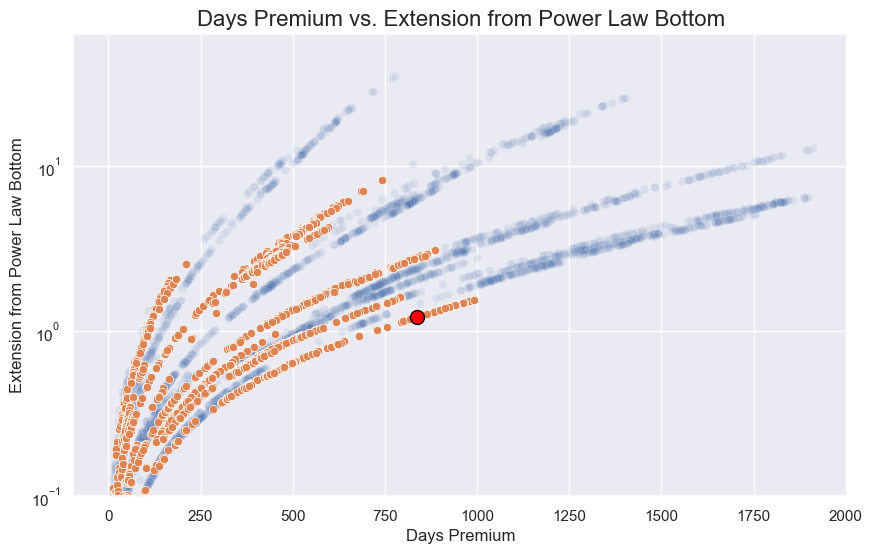

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing: Drop rows with NaN values in the columns of interest
df_cleaned = df.dropna(
    subset=["days_premium", "extension_from_power_law_bottom", "price_went_below"]
)
df[df["price_went_below"] == False]
# Setting the plot style to 'darkgrid' for better readability and aesthetics
sns.set(style="darkgrid")

# Creating the scatter plot with 'price_went_below' as the color dimension
plt.figure(figsize=(10, 6))  # Setting the figure size for better visibility

scatter = sns.scatterplot(
    x="days_premium",
    y="extension_from_power_law_bottom",
    data=df_cleaned[df_cleaned["price_went_below"] == True],
    alpha=0.1
)

scatter = sns.scatterplot(
    x="days_premium",
    y="extension_from_power_law_bottom",
    data=df_cleaned[df_cleaned["price_went_below"] == False],
) 

# Highlighting the most recent price point
# Assuming the DataFrame is sorted in chronological order
latest_point = df_cleaned.iloc[-1]  # Fetching the last row
plt.scatter(
    latest_point["days_premium"],
    latest_point["extension_from_power_law_bottom"],
    color="red",
    s=100,
    edgecolor="black",
    zorder=5,
    label="Current Price",
)

# Setting log scale for y axis
plt.yscale("log")

# Adding limits
plt.ylim(bottom=0.1)

# Enhancements for readability
plt.title(
    "Days Premium vs. Extension from Power Law Bottom",
    fontsize=16,
)
plt.xlabel("Days Premium", fontsize=12)
plt.ylabel("Extension from Power Law Bottom", fontsize=12)

plt.show()

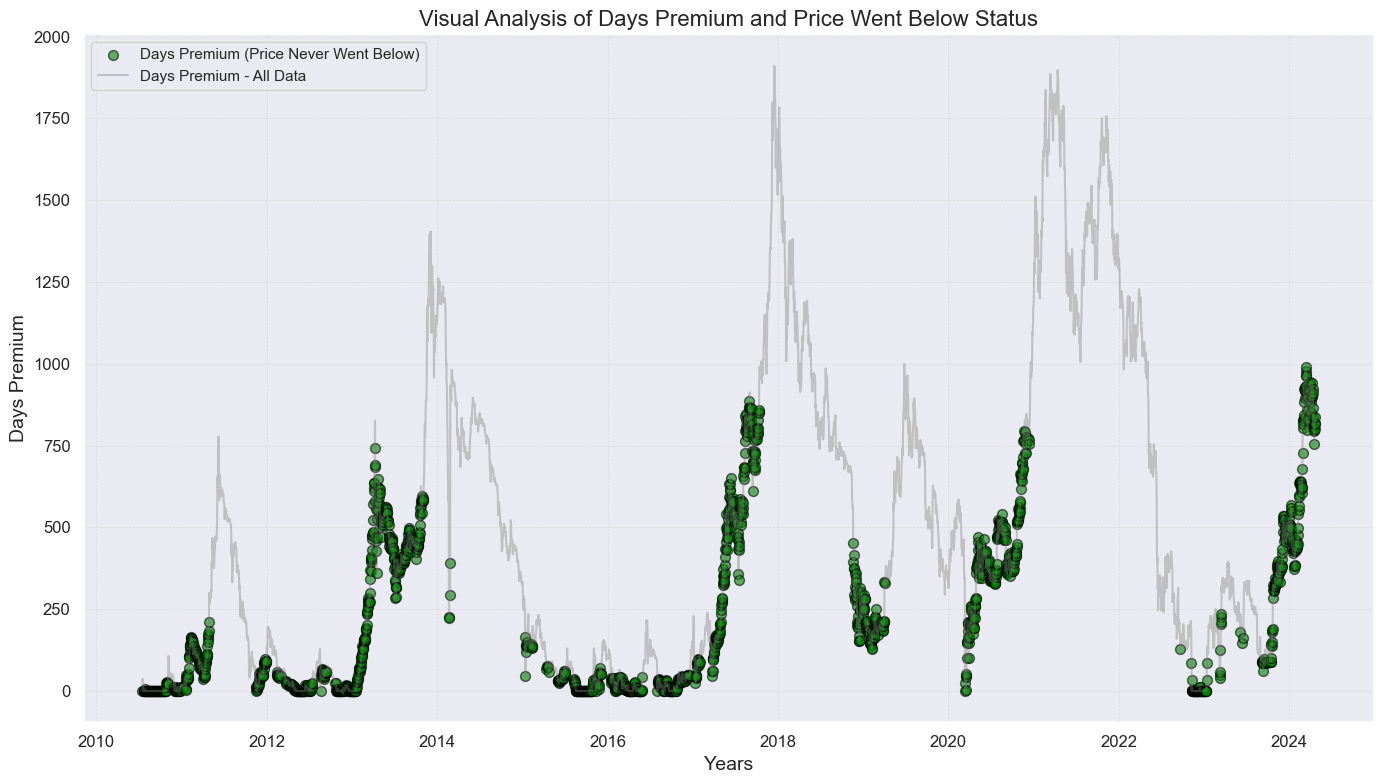

In [12]:
# Assuming df is predefined and has been cleaned up as per your provided script
df_cleaned = df.dropna(subset=["days_premium", "extension_from_power_law_bottom", "price_went_below"])
price_went_below_false = df_cleaned[df_cleaned["price_went_below"] == False]

plt.figure(figsize=(14, 8))  # Larger figure size for better visibility

# Adjusting the opacity and edge color of the main data points
plt.scatter(
    price_went_below_false.index,
    price_went_below_false['days_premium'],
    label='Days Premium (Price Never Went Below)',
    color='green',
    edgecolor='black',
    s=50,  # Smaller markers for a clearer view
    alpha=0.6,  # Adjusting transparency for less dense appearance
)

# The main line plot for days premium with reduced opacity
plt.plot(df.index, df['days_premium'], label='Days Premium - All Data', color='grey', alpha=0.4)

# Adding labels with increased font size for better readability
plt.xlabel('Years', fontsize=14)
plt.ylabel('Days Premium', fontsize=14)

# Adding a title with increased font size
plt.title('Visual Analysis of Days Premium and Price Went Below Status', fontsize=16)

# Adjust the tick parameters for better visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Enable grid, but make it lighter and less obtrusive
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gainsboro')

# Opt for a tight layout to use space effectively
plt.tight_layout()

# Show the legend with an updated location to prevent blocking data points
plt.legend(loc='upper left')

# Show the plot
plt.show()
